In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
from copy import deepcopy
import json
import os
import warnings
from io import BytesIO

import igl
import randomcolor
import trimesh
import k3d
import yaml
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from joblib import Parallel, delayed

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ihldzeai because the default path (/home/user/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
from sharpf.utils.abc_utils.hdf5.dataset import Hdf5File, PreloadTypes
import sharpf.utils.abc_utils.hdf5.io_struct as io_struct
import sharpf.data.datasets.sharpf_io as sharpf_io
import sharpf.utils.plotting as def_plot
from sharpf.utils.abc_utils.mesh.indexing import reindex_zerobased
from sharpf.utils.abc_utils.mesh.io import trimesh_load
import sharpf.data.data_smells as smells


import argparse
from glob import glob
from io import BytesIO
import os
import sys

import igl
import numpy as np
import trimesh.transformations as tt
from tqdm import tqdm
import yaml


from sharpf.data.annotation import ANNOTATOR_BY_TYPE
from sharpf.utils.camera_utils.view import CameraView
from sharpf.data.imaging import RaycastingImaging
from sharpf.utils.py_utils.config import load_func_from_config
from sharpf.utils.camera_utils.camera_pose import CameraPose, camera_to_display
from sharpf.utils.abc_utils.hdf5.dataset import Hdf5File, PreloadTypes
from sharpf.utils.abc_utils.mesh.io import trimesh_load
from sharpf.utils.convertor_utils.convertors_io import (
    AnnotatedViewIO,
    ViewIO,
    write_annotated_views_to_hdf5)
import sharpf.utils.abc_utils.abc.feature_utils as def_feature_utils
from sharpf.utils.convertor_utils.meshlab_project_parsers import load_meshlab_project
import sharpf.utils.convertor_utils.rangevision_utils as rv_utils
from sharpf.utils.camera_utils import matrix
from sharpf.utils.numpy_utils.transformations import transform_to_frame
from sharpf.utils.abc_utils.mesh.indexing import in2d

In [4]:
def display_sharpness(mesh=None, plot_meshvert=True,
                      samples=None, samples_distances=None,
                      sharp_vert=None, sharp_curves=None,
                      directions=None, directions_width=0.0025,
                      samples_color=0x0000ff, samples_psize=0.002, 
                      mesh_color=0xbbbbbb, meshvert_color=0x666666, meshvert_psize=0.0025,
                      sharpvert_color=0xff0000, sharpvert_psize=0.0025,
                      sharpcurve_color=None, sharpcurve_width=0.0025,
                      as_image=False, plot_height=768,
                      cmap=k3d.colormaps.matplotlib_color_maps.coolwarm_r, 
                      plot=None, display=True,
                     max_distance_to_feature=1.0):
    
    if None is plot:
        plot = k3d.plot(height=plot_height, camera_auto_fit=True)
    
    if None is not mesh:
        k3d_mesh = k3d.mesh(mesh.vertices, mesh.faces, color=mesh_color)
        plot += k3d_mesh

        if plot_meshvert:
            k3d_points = k3d.points(mesh.vertices, 
                                    point_size=meshvert_psize, color=meshvert_color)
            plot += k3d_points
            k3d_points.shader='flat'

    if None is not samples:
        colors = None
        if None is not samples_distances and not np.all(samples_distances == 1.0):
            colors = k3d.helpers.map_colors(
                samples_distances, cmap, [0, max_distance_to_feature]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
        else:
            v = -np.array([0., 1., 0.])
            max_dist = np.max(np.dot(samples, v))
            min_dist = np.min(np.dot(samples, v))
            colors = k3d.helpers.map_colors(
                np.dot(samples, v), k3d.colormaps.matplotlib_color_maps.viridis, [min_dist, max_dist]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)

        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not directions:
            colors = k3d.helpers.map_colors(
                samples_distances, cmap, [0, max_distance_to_feature]
            ).astype(np.uint32)
            colors = [(c, c) for c in colors]

            vectors = k3d.vectors(
                samples,
                directions * samples_distances[..., np.newaxis],
                use_head=False, 
                line_width=directions_width,
                colors=colors)
#             print(vectors)
            plot += vectors

#             directions_to_plot = np.hstack((samples, samples + directions))
            
#             for i, dir_to_plot in enumerate(directions_to_plot):
#                 dir_to_plot = dir_to_plot.reshape((2, 3))
#                 if np.all(dir_to_plot[0] == dir_to_plot[1]):
#                     continue
#                 color = int(colors[i]) if None is not colors else samples_color
#                 plt_line = k3d.line(dir_to_plot, 
#                                     shader='mesh', width=directions_width, color=color)
#                 plot += plt_line

    if None is not sharp_vert:
        k3d_points = k3d.points(sharp_vert,
                                point_size=sharpvert_psize, color=sharpvert_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not sharp_curves:            
            if None is not sharpcurve_color:
                color = sharpcurve_color
            else:
                import randomcolor
                rand_color = randomcolor.RandomColor()
            for i, vert_ind in enumerate(sharp_curves):
                sharp_points_curve = mesh.vertices[vert_ind]
                
                if None is sharpcurve_color:
                    color = rand_color.generate(hue='red')[0]
                    color = int('0x' + color[1:], 16)
                plt_line = k3d.line(sharp_points_curve, 
                                    shader='mesh', width=sharpcurve_width, color=color)
                plot += plt_line
        
    plot.grid_visible = False
    if display:
        plot.display()
    
    if as_image:
        plot.fetch_screenshot()
        return Image(data=b64decode(plot.screenshot))
    
    return plot

In [5]:
def bbox_mesh_around_edge(aabbox):
    (x1, y1, z1), (x2, y2, z2) = aabbox
    bbox_mesh = trimesh.creation.box()
    bbox_mesh.vertices = np.array([
        x1, y1, z1,
        x1, y1, z2,
        x1, y2, z1,
        x1, y2, z2,
        x2, y1, z1,
        x2, y1, z2,
        x2, y2, z1,
        x2, y2, z2
    ])
    return bbox_mesh


def display_sharp_edge_bboxes(
    mesh=None, plot_meshvert=False,
    samples=None, samples_distances=None,
    sharp_vert=None, sharp_curves=None,
    sharp_aabboxes=None,
    directions=None, directions_width=0.0025,
    samples_color=0x0000ff, samples_psize=0.002, 
    mesh_color=0xbbbbbb, meshvert_color=0x666666, meshvert_psize=0.0025,
    sharpvert_color=0xff0000, sharpvert_psize=0.0025,
    sharpcurve_color=None, sharpcurve_width=0.0025,
    as_image=False, plot_height=768,
    cmap=k3d.colormaps.matplotlib_color_maps.coolwarm_r, 
    plot=None, display=True,
    max_distance_to_feature=1.0, 
):
    
    plot = k3d.plot(
        height=plot_height, 
        camera_auto_fit=True, 
        grid_visible=False)
    
    if None is not mesh:
        k3d_mesh = k3d.mesh(mesh.vertices, mesh.faces, color=mesh_color)
        plot += k3d_mesh

        if plot_meshvert:
            k3d_points = k3d.points(mesh.vertices, 
                                    point_size=meshvert_psize, color=meshvert_color)
            plot += k3d_points
            k3d_points.shader='flat'

    if None is not samples:
        colors = None
        if None is not samples_distances and not np.all(samples_distances == 1.0):
            colors = k3d.helpers.map_colors(
                samples_distances, cmap, [0, max_distance_to_feature]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
        else:
            v = -np.array([0., 1., 0.])
            max_dist = np.max(np.dot(samples, v))
            min_dist = np.min(np.dot(samples, v))
            colors = k3d.helpers.map_colors(
                np.dot(samples, v), k3d.colormaps.matplotlib_color_maps.viridis, [min_dist, max_dist]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)

        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not directions:
            colors = k3d.helpers.map_colors(
                samples_distances, cmap, [0, max_distance_to_feature]
            ).astype(np.uint32)
            colors = [(c, c) for c in colors]

            vectors = k3d.vectors(
                samples,
                directions * samples_distances[..., np.newaxis],
                use_head=False, 
                line_width=directions_width,
                colors=colors)
            plot += vectors


    if None is not sharp_vert:
        k3d_points = k3d.points(sharp_vert,
                                point_size=sharpvert_psize, color=sharpvert_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not sharp_curves:            
            if None is not sharpcurve_color:
                color = sharpcurve_color
            else:
                import randomcolor
                rand_color = randomcolor.RandomColor()
            for i, vert_ind in enumerate(sharp_curves):
                sharp_points_curve = mesh.vertices[vert_ind]
                
                if None is sharpcurve_color:
                    color = rand_color.generate(hue='red')[0]
                    color = int('0x' + color[1:], 16)
                plt_line = k3d.line(sharp_points_curve, 
                                    shader='mesh', width=sharpcurve_width, color=color)
                plot += plt_line
        
    if None is not sharp_aabboxes:
        for aabbox in sharp_aabboxes:
            aabbox_mesh = bbox_mesh_around_edge(aabbox)
            plot += k3d.mesh(
                aabbox_mesh.vertices,
                aabbox_mesh.faces,
                flat_shading=False,
                color=sharpvert_color,
                wireframe=True,
            )
    
    plot.display()

In [6]:
from sharpf.utils.convertor_utils.convertors_io import ViewIO, RangeVisionIO

def get_mesh(hdf5_filename, obj_mesh):
    dataset = Hdf5File(
        hdf5_filename,
        io=ViewIO,
        preload=PreloadTypes.LAZY,
        labels='*')

    with open(obj_filename, 'rb') as obj_file:
        obj_mesh, _, _ = trimesh_load(BytesIO(obj_file.read()))


    obj_alignment_transform = dataset[0]['obj_alignment']
    obj_scale = dataset[0]['obj_scale']
    mesh = obj_mesh.copy() \
        .apply_scale(obj_scale) \
        .apply_transform(obj_alignment_transform)
    
    return mesh

In [7]:
def fuse_points(n_points, list_predictions, list_indexes_in_whole, list_points):
    fused_points = np.zeros((n_points, 3))
    fused_distances = np.ones(n_points) * np.inf
    # fused_directions = np.ones((n_points, 3)) * np.inf

    iterable = zip(list_predictions, list_indexes_in_whole, list_points)
    for distances, indexes, points in tqdm(iterable):
        fused_points[indexes] = points
        assign_mask = fused_distances[indexes] > distances
        fused_distances[indexes[assign_mask]] = np.minimum(distances[assign_mask], 2.5)
        # fused_directions[indexes[assign_mask]] = directions[assign_mask]

    return fused_points, fused_distances, {}

In [8]:
input_dir = '/data/todo/3side/'
max_distance_to_feature = 10.0
max_point_mesh_distance = 4.0
full_mesh = True

In [9]:
stl_filename = glob(os.path.join(input_dir, '*.stl'))[0]
obj_filename = glob(os.path.join(input_dir, '*.obj'))[0]
yml_filename = glob(os.path.join(input_dir, '*.yml'))[0]
hdf5_filename = glob(os.path.join(input_dir, '*_preprocessed.hdf5'))[0]
item_id = os.path.basename(stl_filename).split('__')[0]

In [10]:
print('Reading input data...', end='')
with open(obj_filename, 'rb') as obj_file:
    print('obj...', end='')
    obj_mesh, _, _ = trimesh_load(BytesIO(obj_file.read()))

with open(yml_filename, 'rb') as yml_file:
    print('yml...', end='')
    yml_features = yaml.load(BytesIO(yml_file.read()), Loader=yaml.Loader)

print('hdf5...')
dataset = Hdf5File(
    hdf5_filename,
    io=ViewIO,
    preload=PreloadTypes.LAZY,
    labels='*')


Reading input data...obj...yml...hdf5...


In [67]:
obj_alignment_transform = dataset[0]['obj_alignment']
obj_scale = dataset[0]['obj_scale']
mesh = obj_mesh.copy() \
    .apply_scale(obj_scale) \
    .apply_transform(obj_alignment_transform)

views = [
    CameraView(
        depth=scan['points'].reshape((-1, 3)),
        signal=None,
        faces=scan['faces'].reshape((-1, 3)),
        extrinsics=scan['extrinsics'],
        intrinsics=scan['intrinsics'],
        state='points')
    for scan in tqdm(dataset, desc='Loading scans')]
view_alignments = [scan['points_alignment'] for scan in dataset]

Loading scans: 100%|██████████| 12/12 [00:00<00:00, 7468.71it/s]


In [68]:
os.environ['OMP_NUM_THREADS'] = '36'

# Prepare annotation stuff
annotation_config = {
    "type": "surface_based_aabb",
    "distance_upper_bound": max_distance_to_feature,
    "always_check_adjacent_surfaces": True,
    "distance_computation_method": 'geom',
}
annotator = load_func_from_config(ANNOTATOR_BY_TYPE, annotation_config)
smell_sharpness_discontinuities = smells.SmellSharpnessDiscontinuities.from_config({})


{'surface_based_aabb': <class 'sharpf.data.annotation.AABBSurfacePatchAnnotator'>} {'type': 'surface_based_aabb', 'distance_upper_bound': 10.0, 'always_check_adjacent_surfaces': True, 'distance_computation_method': 'geom'}


In [69]:
view, view_alignment = views[0].copy(), view_alignments[0]

points = view.depth
aligned_points = tt.transform_points(points, view_alignment)


In [70]:
# select only well-aligned points
point_mesh_distance, mesh_face_indexes, _ = igl.point_mesh_squared_distance(
    aligned_points,
    mesh.vertices,
    mesh.faces)
well_aligned_mask = np.sqrt(point_mesh_distance) < max_point_mesh_distance


In [71]:
_ = display_sharpness(
    mesh,
    plot_meshvert=False,
    samples=aligned_points,
    samples_psize=0.5,
    samples_distances=well_aligned_mask.astype(float),
    cmap=k3d.colormaps.matplotlib_color_maps.plasma)

Output()

In [72]:
aligned_points = aligned_points[well_aligned_mask]
mesh_face_indexes = mesh_face_indexes[well_aligned_mask]


In [73]:
_ = display_sharpness(
    mesh,
    plot_meshvert=False,
    samples=aligned_points,
    samples_psize=0.5,
    cmap=k3d.colormaps.matplotlib_color_maps.plasma)

Output()

In [74]:
if full_mesh:
    nbhood = mesh
    nbhood_features = yml_features
    mesh_vertex_indexes = np.arange(len(mesh.vertices))
    mesh_face_indexes = np.arange(len(mesh.faces))

else:
    nbhood, mesh_vertex_indexes, mesh_face_indexes = \
        submesh_from_hit_surfaces(mesh, yml_features, mesh_face_indexes)

    # create annotations: condition the features onto the nbhood
    nbhood_features = compute_features_nbhood(
        mesh,
        yml_features,
        mesh_face_indexes,
        mesh_vertex_indexes=mesh_vertex_indexes)

    # remove vertices lying on the boundary (sharp edges found in 1 face only)
    nbhood_features = remove_boundary_features(
        nbhood,
        nbhood_features,
        how='edges')

distances, directions, has_sharp = annotator.annotate(
    nbhood,
    nbhood_features,
    aligned_points)
has_smell_sharpness_discontinuities = smell_sharpness_discontinuities.run(aligned_points, distances)

In [75]:
_ = display_sharpness(
    mesh,
    plot_meshvert=False,
    samples=aligned_points,
    samples_psize=0.5,
    samples_distances=distances,
    cmap=k3d.colormaps.matplotlib_color_maps.plasma_r,
    max_distance_to_feature=max_distance_to_feature)

Output()

In [76]:
view.depth = points[well_aligned_mask]
view.signal = np.hstack((np.atleast_2d(distances).T, directions))

pixel_view = view.to_pixels()
image = pixel_view.depth
distances, directions = pixel_view.signal[:, :, 0], pixel_view.signal[:, :, 1:]


In [77]:
pixel_view_original = views[0].to_pixels()
image_original = pixel_view_original.depth


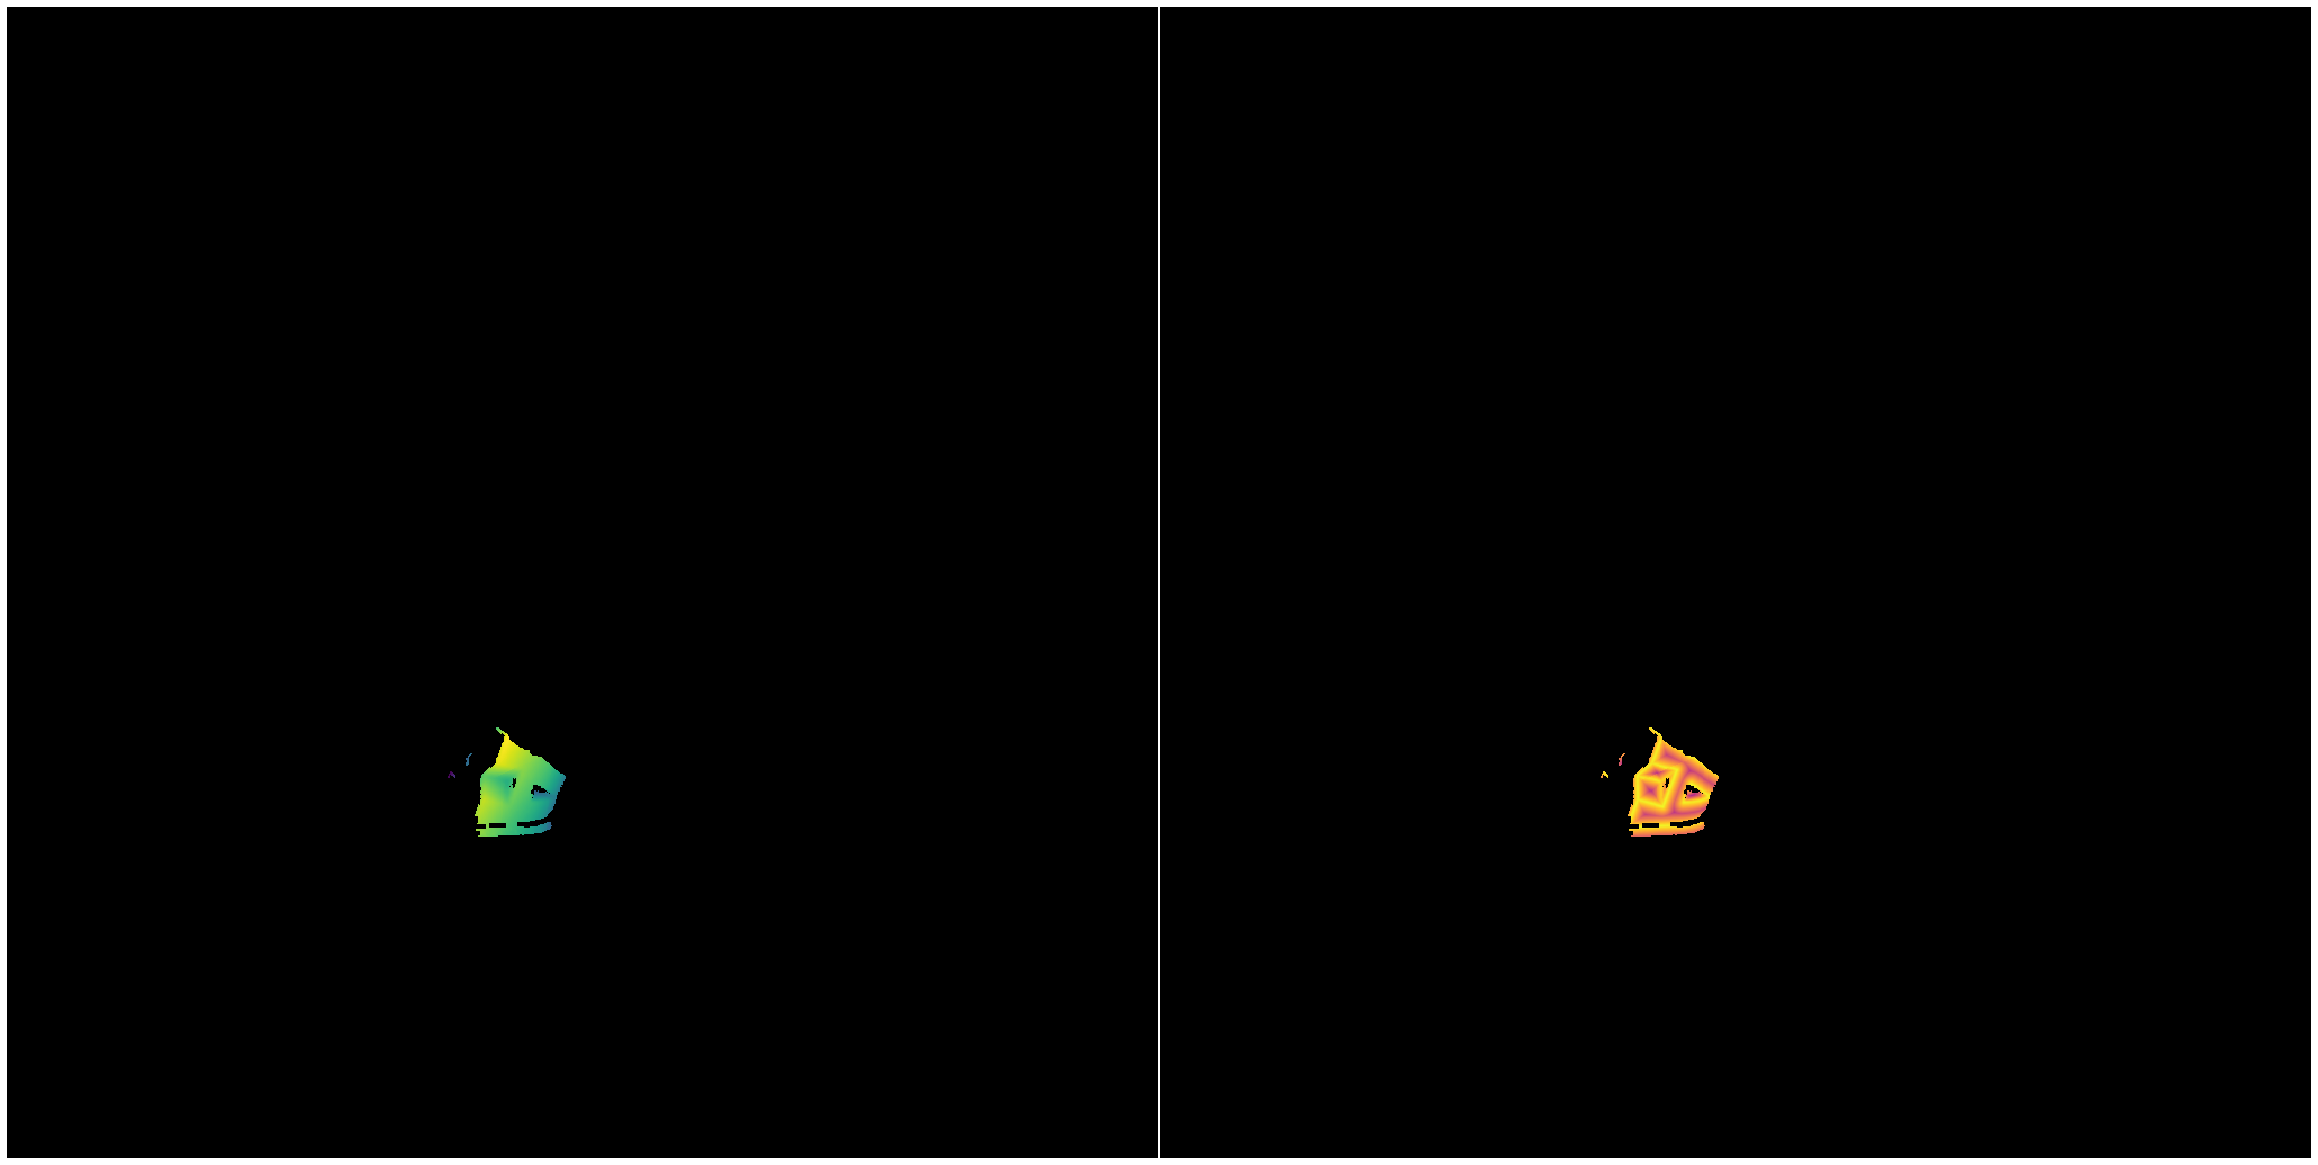

In [78]:
s = 512
depth_images_for_display = [
    image[
        slice(1536 // 2 - s, 1536 // 2 + s),
        slice(2048 // 2 - s, 2048 // 2 + s)]
]
sharpness_images_for_display = [
    distances[
        slice(1536 // 2 - s, 1536 // 2 + s),
        slice(2048 // 2 - s, 2048 // 2 + s)]
]

def_plot.display_depth_sharpness(
    depth_images=depth_images_for_display,
    sharpness_images=sharpness_images_for_display,
    ncols=1,
    axes_size=(16, 16),
    max_sharpness=max_distance_to_feature,
    bgcolor='black')

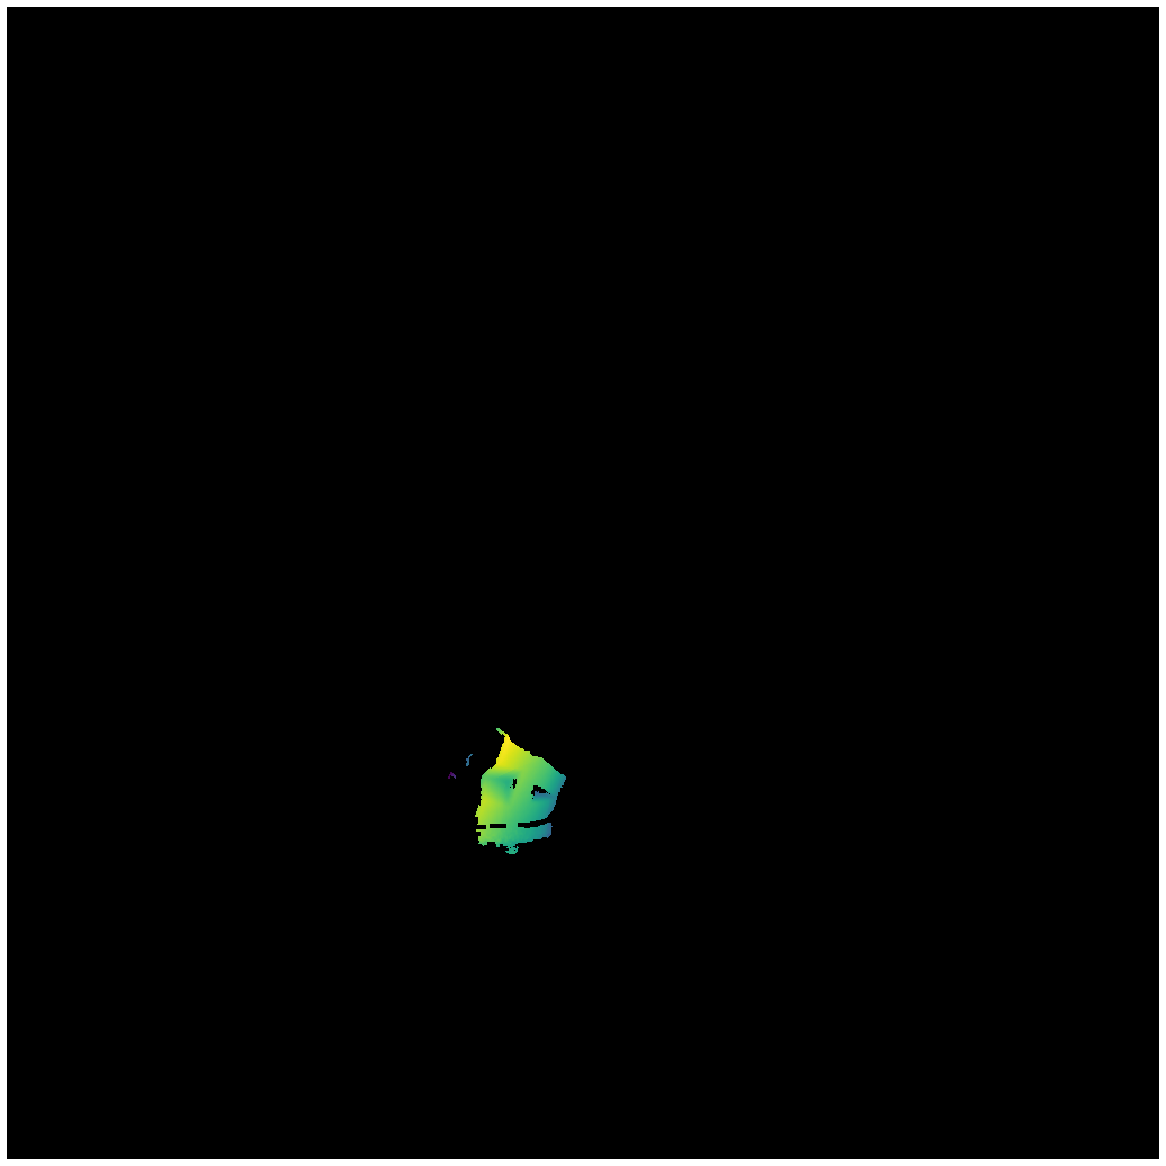

In [79]:
s = 512
depth_images_for_display = [
    image_original[
        slice(1536 // 2 - s, 1536 // 2 + s),
        slice(2048 // 2 - s, 2048 // 2 + s)]
]
# sharpness_images_for_display = [
#     distances[
#         slice(1536 // 2 - s, 1536 // 2 + s),
#         slice(2048 // 2 - s, 2048 // 2 + s)]
# ]

def_plot.display_depth_sharpness(
    depth_images=depth_images_for_display,
    sharpness_images=None,
    ncols=1,
    axes_size=(16, 16),
    max_sharpness=max_distance_to_feature,
    bgcolor='black')

In [ ]:
surfaces_ids_bad = [0, 14]

In [ ]:
# display_patch_decomposition(mesh, yml_features)

In [ ]:
sharp_vert_indexes = np.concatenate(
    [c['vert_indices'] for c in yml_features['curves'] if c['sharp']]
)
sharp_vert = nbhood.vertices[sharp_vert_indexes]


_ = display_sharpness(
    mesh=nbhood,
    samples=aligned_points,
    samples_distances=distances,
    samples_psize=0.5,
    directions=directions,
    sharp_vert=sharp_vert,
    sharpvert_psize=0.75,
    max_distance_to_feature=max_distance_to_feature,
)

In [ ]:
annotator.annotate??

In [ ]:
mesh_patch = deepcopy(nbhood)
features_patch = deepcopy(nbhood_features)
points = deepcopy(aligned_points)

# index mesh vertices to search for closest sharp features
# tree = KDTree(mesh_patch.vertices, leafsize=100)
# _, closest_nbhood_vertex_idx = tree.query(points)
_, point_face_indexes, _ = \
    igl.point_mesh_squared_distance(points, mesh_patch.vertices, mesh_patch.faces)

# understand which surface patches are adjacent to which sharp features
# and other surface patches
adjacent_sharp_features, adjacent_surfaces = \
    def_feature_utils.build_surface_patch_graph(mesh_patch, features_patch)


# features_patch['surfaces'] = [
#     surface for surface_idx, surface in enumerate(features_patch['surfaces']) 
#     if surface_idx not in surfaces_ids_bad]
# curves_ids_bad = []
# for surface_idx in surfaces_ids_bad:
#     curves_ids_bad.extend(adjacent_sharp_features[surface_idx])
# features_patch['curves'] = [
#     curve for curve_idx, curve in enumerate(features_patch['curves']) 
#     if curve_idx not in curves_ids_bad]

# understand which surface patches are adjacent to which sharp features
# and other surface patches
adjacent_sharp_features, adjacent_surfaces = \
    def_feature_utils.build_surface_patch_graph(mesh_patch, features_patch)


# compute distance, iterating over points sampled from corresponding surface patches
projections, distances, _ = annotator.flat_annotation(points)

In [ ]:
def parallel_annotation_by_surface(
        mesh_patch,
        features_patch,
        points,
        surface_idx,
        point_face_indexes,
        adjacent_sharp_features,
        adjacent_surfaces,
        annotator_obj
):
    surface = features_patch['surfaces'][surface_idx]
    # constrain distance computation to certain sharp features only
    adjacent_sharp_indexes = def_feature_utils.get_adjacent_features_by_bfs_with_depth1(
        surface_idx,
        adjacent_sharp_features,
        adjacent_surfaces,
        always_check_adjacent_surfaces=annotator_obj.always_check_adjacent_surfaces)
    surface_adjacent_features = {
        'curves': [features_patch['curves'][idx]
                   for idx in np.unique(adjacent_sharp_indexes)]
    }
    if len(surface_adjacent_features['curves']) == 0:
        return [None] * 4

    point_cloud_indexes = np.where(
        in2d(mesh_patch.faces[point_face_indexes], 
             mesh_patch.faces[surface['face_indices']])
    )[0]
    if len(point_cloud_indexes) == 0:
        return [None] * 4

    # compute distances using parent class AABB method
#     surface_matching_edges, surface_projections, surface_distances = \
#         annotator_obj.compute_aabb_nearest_points(
#         mesh_patch, 
#         surface_adjacent_features, 
#         points[point_cloud_indexes])

    aabboxes, sharp_edges = annotator_obj._prepare_aabb(mesh_patch, surface_adjacent_features)
    surface_distances, surface_projections = find_projections_onto_edges(points[point_cloud_indexes], sharp_edges)
#     directions = projections - points[point_cloud_indexes]
#     directions /= (np.linalg.norm(directions, axis=1, keepdims=True) + 1e-6)

    surface_matching_edges = None
    return point_cloud_indexes, surface_matching_edges, surface_projections, surface_distances


In [ ]:
sharp_edges = annotator._prepare_aabb(nbhood,
        nbhood_features)

In [ ]:
def find_projections_onto_edges(
    points, 
    edges,
):
    distances = np.zeros(len(points))
    projections = np.zeros_like(points)
    for point_idx, point in tqdm(enumerate(points)):
        distances_projections = [dist_vector_proj(point, i, edges) for i in range(len(edges))]
        projection_idx = np.argmin([d for d, p in distances_projections])
        distances[point_idx], projections[point_idx] = distances_projections[projection_idx]
        
    return distances, projections

In [ ]:
surface_idx = 6
annotator_obj = annotator
args = (
    mesh_patch,
    features_patch,
    points,
    surface_idx,
    point_face_indexes,
    adjacent_sharp_features,
    adjacent_surfaces,
    annotator_obj)

In [ ]:
point_cloud_indexes, _, surface_projections, surface_distances = parallel_annotation_by_surface(*args)
surface_directions = surface_projections - points[point_cloud_indexes]
surface_directions /= (np.linalg.norm(surface_directions, axis=1, keepdims=True) + 1e-6)

In [ ]:
sharp_vert_indexes = np.concatenate(
    [c['vert_indices'] for c in features_patch['curves'] if c['sharp']]
)
sharp_vert = nbhood.vertices[sharp_vert_indexes]


display_sharpness(
    mesh=nbhood,
    plot_meshvert=False,
    samples=points[point_cloud_indexes],
    samples_distances=surface_distances,
    samples_psize=0.5,
    directions=surface_directions,
    sharp_vert=sharp_vert,
    sharpvert_psize=0.75,
    max_distance_to_feature=max_distance_to_feature,
)

In [ ]:
from pyaabb import pyaabb
from sharpf.utils.geometry import dist_vector_proj
from functools import partial

In [ ]:
surface = features_patch['surfaces'][surface_idx]
# constrain distance computation to certain sharp features only
adjacent_sharp_indexes = def_feature_utils.get_adjacent_features_by_bfs_with_depth1(
    surface_idx,
    adjacent_sharp_features,
    adjacent_surfaces,
    always_check_adjacent_surfaces=annotator_obj.always_check_adjacent_surfaces)

# surface_adjacent_features = {
#     'curves': [features_patch['curves'][idx]
#                for idx in np.unique(adjacent_sharp_indexes)]
# }
surface_adjacent_features = {
    'curves': [features_patch['curves'][idx]
               for idx in adjacent_sharp_features[surface_idx]]
}

if len(surface_adjacent_features['curves']) == 0:
    print('no features')

point_cloud_indexes = np.where(
    in2d(mesh_patch.faces[point_face_indexes], 
         mesh_patch.faces[surface['face_indices']])
)[0]
if len(point_cloud_indexes) == 0:
    print('no features')


# # compute distances using parent class AABB method
# surface_matching_edges, surface_projections, surface_distances = \
#     annotator_obj.compute_aabb_nearest_points(
#     mesh_patch, 
#     surface_adjacent_features, 
#     pointsaligned_points[point_cloud_indexes])

aabboxes, sharp_edges = annotator_obj._prepare_aabb(mesh_patch, surface_adjacent_features)

aabb_solver = pyaabb.AABB()
aabb_solver.build(aabboxes)
distance_func = partial(dist_vector_proj, lines=sharp_edges)
results = [
    aabb_solver.nearest_point(p, distance_func)
    for p in points[point_cloud_indexes]]

surface_matching_edges = np.array([idx for idx, projection, distance in results])
surface_projections = np.array([projection for idx, projection, distance in results])
surface_distances = np.array([distance for idx, projection, distance in results])

directions = surface_projections - points[point_cloud_indexes]
directions /= (np.linalg.norm(directions, axis=1, keepdims=True) + 1e-6)

In [ ]:
display_sharp_edge_bboxes(
    mesh=nbhood,
    plot_meshvert=False,
    sharp_aabboxes=aabboxes
)

In [ ]:
# aabb_samples = np.array([bbox[0] for bbox in aabboxes])
# aabb_projections = np.array([bbox[1] for bbox in aabboxes])
# aabb_directions = aabb_projections - aabb_samples

# display_sharpness(
#     mesh=nbhood,
#     plot_meshvert=False,
#     samples=aabb_samples,
#     samples_distances=np.ones(len(aabb_samples)),
#     samples_psize=0.5,
#     directions=aabb_directions,
#     directions_width=0.1,
#     sharp_vert=sharp_edges,
#     sharpvert_psize=0.75,
#     max_distance_to_feature=max_distance_to_feature,
# )

In [ ]:
xx_edge, xx_projection, xx_distance = \
  aabb_solver.nearest_point(points[point_cloud_indexes][104], distance_func)

In [ ]:
points[point_cloud_indexes][104]

In [ ]:
x = [dist_vector_proj(
    points[point_cloud_indexes][104],
    i,
    sharp_edges)
for i in range(len(sharp_edges))]


x_samples = np.repeat(np.atleast_2d(points[point_cloud_indexes[0]]), len(sharp_edges), axis=0)
x_projections = np.array([xx[1] for xx in x])
x_distances = np.linalg.norm(x_projections - x_samples, axis=1, keepdims=False)
x_directions = (x_projections - x_samples)
x_directions /= (np.linalg.norm(x_directions, axis=1, keepdims=True) + 1e-6)

display_sharpness(
    mesh=nbhood,
    plot_meshvert=False,
    samples=x_samples,
    samples_distances=x_distances,
    samples_psize=0.5,
    directions=x_directions,
    directions_width=0.5,
    sharp_vert=np.concatenate(([xx_projection], sharp_edges[xx_edge])),
    sharpvert_psize=0.75,
    max_distance_to_feature=max_distance_to_feature,
)

In [ ]:
distances, projections = find_projections_onto_edges(points[point_cloud_indexes], sharp_edges)
directions = projections - points[point_cloud_indexes]
directions /= (np.linalg.norm(directions, axis=1, keepdims=True) + 1e-6)

In [ ]:
sharp_vert_indexes = np.concatenate(
    [c['vert_indices'] for c in surface_adjacent_features['curves'] if c['sharp']]
)
sharp_vert = nbhood.vertices[sharp_vert_indexes]


display_sharpness(
    mesh=nbhood,
    plot_meshvert=False,
    samples=points[point_cloud_indexes],
    samples_distances=distances,
    samples_psize=0.5,
    directions=directions,
    sharp_vert=sharp_edges,
    sharpvert_psize=0.75,
    max_distance_to_feature=max_distance_to_feature,
)

In [ ]:
idx = np.random.choice(len(point_face_indexes))

submesh = reindex_zerobased(mesh, mesh_patch.faces[point_face_indexes[idx]], point_face_indexes[idx])

plot = k3d.plot(grid_visible=False, height=768)

plot += k3d.mesh(
    mesh_patch.vertices,
    mesh_patch.faces,
    flat_shading=False,
    color=0xdddddd,
    side='both',
    wireframe=False)

plot += k3d.mesh(
    submesh.vertices,
    submesh.faces,
    flat_shading=False,
    color=0xff0000,
    side='both',
    wireframe=False)

plot += k3d.points(
    points[idx],
    color=get_random_color(hue='green'),
    side='both', 
    shader='flat',
    point_size=0.25)

plot.display()

In [ ]:
idx, point_face_indexes[idx]

In [ ]:
pixel_views = [view.to_pixels() for view in views]

s = 256
depth_images_for_display = [
    view.depth[
        slice(1536 // 2 - s, 1536 // 2 + s),
        slice(2048 // 2 - s, 2048 // 2 + s)]
    for view in pixel_views]
sharpness_images_for_display = None
# [
#     view.signal[
#         slice(1536 // 2 - s, 1536 // 2 + s),
#         slice(2048 // 2 - s, 2048 // 2 + s)]
#     for view in pixel_views]
display_depth_sharpness(
    depth_images=depth_images_for_display,
    sharpness_images=sharpness_images_for_display,
    ncols=2,
    axes_size=(16, 16*3),
    max_sharpness=max_distance_to_feature)

In [ ]:
from functools import partial

import numpy as np
from scipy.spatial.ckdtree import cKDTree

# from sharpf.utils.py_utils.parallel import loky_parallel

import os

from joblib import Parallel, delayed


def omp_parallel(func, iterable, backend='threading'):
    n_omp_threads = int(os.environ.get('OMP_NUM_THREADS', 1))
    parallel = Parallel(n_jobs=n_omp_threads, backend=backend)

    def ensure_tuple(args):
        return args if isinstance(args, tuple) else (args,)

    delayed_iterable = (delayed(func)(*ensure_tuple(args)) for args in iterable)
    return parallel(delayed_iterable)


def threaded_parallel(func, iterable):
    return omp_parallel(func, iterable, backend='threading')


def multiproc_parallel(func, iterable):
    return omp_parallel(func, iterable, backend='multiprocessing')


def loky_parallel(func, iterable):
    return omp_parallel(func, iterable, backend='loky')



def point_edgeset_squared_distance(p, i, lines):
    """A helper function that computes distance from a point
    to a line segment using a vector projection."""
    v1, v2 = lines[i]

    # compute unit norm vector from v2 to v1 (linear subspace spanning line)
    line_tangent = v2 - v1
    line_tangent_norm = np.linalg.norm(line_tangent)
    line_tangent = line_tangent / line_tangent_norm

    # subtract tangential component, obtain point in L^T(line_tangent)
    projection_diff = p - v1 - np.dot(p - v1, line_tangent) * line_tangent
    projection_diff_norm = np.linalg.norm(projection_diff)

    # compute line parameter value for projection
    projection = p - projection_diff
    t = np.dot(projection - v1, line_tangent) / line_tangent_norm

    assert (np.linalg.norm(
        ((1 - t) * v1 + t * v2) - projection) < 1e-10)

    # compare distances to projection, v1 and v2, choose minimum
    if 0 <= t <= 1:
        return projection_diff_norm, projection
    else:
        proj_v1, proj_v2 = np.linalg.norm(p - v1), np.linalg.norm(p - v2)
        if proj_v1 < proj_v2:
            return proj_v1, v1
        else:
            return proj_v2, v2


def point_edgeset_projection(point, edges):
    """For a single given point from a point set, compute its projection
    onto a closest set from a given edge set. The edge set
    must be given as a list of (XYZ_1, XYZ_2) pairs of edge
    endpoints."""
    distances_projections = [
        point_edgeset_squared_distance(point, i, edges)
        for i in range(len(edges))]
    projection_idx = np.argmin([d for d, p in distances_projections])
    return distances_projections[projection_idx]


def pointset_edgeset_projections(points, edges):
    """For each point from a point set, compute its projection
    onto a closest set from a given edge set. The edge set
    must be given as a list of (XYZ_1, XYZ_2) pairs of edge
    endpoints."""
    distances = np.zeros(len(points))
    projections = np.zeros_like(points)
    for point_idx, point in tqdm(enumerate(points)):
        distances[point_idx], projections[point_idx] = point_edgeset_projection(point, edges)
    return distances, projections


def parallel_pointset_edgeset_projections(points, edges):
    """A multiprocessing version of ."""
    distances = np.zeros(len(points))
    projections = np.zeros_like(points)

    def _point_edgeset_projection_with_index(index, point, edges):
        distance, projection = point_edgeset_projection(point, edges)
        return index, distance, projection

    fn = _point_edgeset_projection_with_index
    it = ((index, point, edges) for index, point in enumerate(points))
    for point_idx, distance, projection in loky_parallel(fn, it):
        distances[point_idx], projections[point_idx] = distance, projection
    return distances, projections

    

In [ ]:
os.environ['OMP_NUM_THREADS'] = '20'

In [ ]:
parallel_pointset_edgeset_projections(points, sharp_edges[1])